# Anti-Asian-Hate Trend Analysis

## Task: import data

### Import packages

In [ ]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
from pathlib import Path
import numpy as np
path = Path.cwd() # current working directory

# NLP Imports
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import preprocessor as p

from scipy.stats import ttest_ind
from segtok.segmenter import split_single
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import gensim.corpora as corpora
import gensim
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
from pprint import pprint
import pyLDAvis
import pyLDAvis.gensim_models
import pickle 
from collections import defaultdict
from wordcloud import WordCloud
from PIL import Image

#nltk.download('wordnet')
#nltk.download('punkt')
from tqdm import tqdm

### Sample Data Parsing for event 2

In [ ]:
# This code shows how to scrape twitter by using the snscrape python API
# Please make sure the snscrape has been installed in the local environment
# The snscape package can be installed by: pip3 install git+https://github.com/JustAnotherArchivist/snscrape.git
# The Python version has to be greater than 3.8
# An alternative Python method is to to execute CLI commands in Python. 
# Please check this link for more details: https://colab.research.google.com/drive/1ugr1biGxV9C2OwzS3HEh3KM0z2Xg44jb?usp=sharing

key_word = "#StopAsianHate"  # Declare the key word used to search tweets
from_date = "2021-03-17" # Declare a start date
end_date = '2021-03-22'  # Declare a end date
count = 5000           # The maximum number of tweets
tweets_list_keyword = [] # A list used to store the returned results for keyword search
tweets_list_user = []    # A list used to store the retuned results for user search


#### Scraping tweets from a text search query ####
command_keyword = key_word+' since:'+from_date+' until:'+end_date # Define a string command for Scraper Api
print("Scraping data for keyword:",key_word)
for i,tweet in enumerate(sntwitter.TwitterSearchScraper(command_keyword).get_items()):
    tweets_list_keyword.append([tweet.id, tweet.content, tweet.user.username, tweet.user.followersCount,tweet.user.listedCount,tweet.retweetedTweet]) # Append returned results to list
    if i>count:
        break;
#Create a dataframe from the tweets list above 
tweets_df_keyword = pd.DataFrame(tweets_list_keyword, columns=['Tweet Id', 'Text', 'Username', 'followers','listedcount','retweeted'])
tweets_df_keyword.to_csv("after_316.csv",index=False) # Export to a csv file
print("Scraped data have been exported to the csv file")

## Task: Analyze Event1
### Donald Trump’s public statement about the “Chinese Virus” in 2020

Using March 18th, 2020 as a split point. We scrapped 5000 posts that contained
the hashtag #chinesevirus both one week before and after the 18th.

In [ ]:
df_before = pd.read_csv("before_318.csv")
df_after = pd.read_csv("after318.csv")

### Sentiment Analysis on Tweets before and After Trump's China Virus Statement

For sentiment analysis, we utilized two packages: FlairNLP and Hatesonar.
FlairNLP helps calculate the sentiment scores for the texts. A positive score will
represent a positive attitude while a negative score represents a negative attitude. The
hatesonar package is developed by an individual developer and it can provide hate and
offensive scores. However, it is not widely used. Thus, we only take the scores
generated by hatesonar as a reference.

In [ ]:
stop_words = set(stopwords.words("english"))
more_stopwords = {'&amp', 'amp'}
stop_words = stop_words.union(more_stopwords)

def preprocessor(text):
    #preprocessor package for tweets cleaning
    p.set_options(p.OPT.URL, p.OPT.EMOJI)
    text = p.clean(text)        
    #remove stopwords
    tokenized = word_tokenize(text)
    text = [w for w in tokenized if not w in stop_words]
    text = " ".join(text)
    
    return text  

In [ ]:
before = df_before.Text.apply(preprocessor).to_list()
before = [x.lower() for x in before]
after = df_after.Text.apply(preprocessor).to_list()
after= [x.lower() for x in after]
before_text = []
for i in range(len(before)):
    text = before[i].replace('#', '')
    before_text.append(text)

after_text = []
for i in range(len(after)):
    text = after[i].replace('#', '')
    after_text.append(text)

### Calculate the negative and positive score of each tweet

In [ ]:
from hatesonar import Sonar
sonar = Sonar()
hate_score = []
offensive_score = []
for i in before_text:
    x = sonar.ping(text=i)
    hate_score.append(x['classes'][0]['confidence'])
    offensive_score.append(x['classes'][1]['confidence'])

In [ ]:
df_before['hate'] = hate_score
df_before['offensive'] = offensive_score
df_before['hate'].mean()
df_before['offensive'].mean()

### Calculate the positive and positive score of each tweet

In [ ]:
from hatesonar import Sonar
sonar = Sonar()
hate_score = []
offensive_score = []
for i in after_text:
    x = sonar.ping(text=i)
    hate_score.append(x['classes'][0]['confidence'])
    offensive_score.append(x['classes'][1]['confidence'])

In [ ]:
df_after['hate'] = hate_score
df_after['offensive'] = offensive_score
df_after['hate'].mean()
df_after['offensive'].mean()

In [ ]:
import flair
flair_sentiment = flair.models.TextClassifier.load('en-sentiment')

In [ ]:
def senti_score(n):
    s = flair.data.Sentence(n)
    flair_sentiment.predict(s)
    total_sentiment = s.labels[0]
    assert total_sentiment.value in ['POSITIVE', 'NEGATIVE']
    sign = 1 if total_sentiment.value == 'POSITIVE' else -1
    score = total_sentiment.score
    return sign * score

In [ ]:
score_after = []
for t in after_text:
    scores = senti_score(t)
    score_after.append(scores)

In [ ]:
score_before = []
for t in before_text:
    scores = senti_score(t)
    score_before.append(scores)

In [ ]:
import statistics
statistics.mean(score_after)
statistics.mean(score_before)

Based on hatesonar, the average hate score before March 18th is 0.0495 and
the average offensive score is equal to 0.3477. For the after tweets, the hate score is
0.0503 and the average offensive score is 0.3415. We can see that the hate score
increases a little bit after the 18th, while the offensive score drops a little. Continuing the
sentiment analysis using FlairNLP, we have obtained a sentiment score of -0.67466 for
the before tweets and a score of -0.70929 for the after tweets. Based on the scores, we
can observe that tweets related to #chinesevirus were getting more negative after
trump’s statement.

### Wordcloud

In [ ]:
icon = Image.open("123.png")
image_mask = Image.new(mode='RGB', size = icon.size, color = (255,255,255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) #converts the image object to an array

In [ ]:
before_str = ' '.join(before_text)
before_str = before_str.replace('chinavirus', '')
before_str = before_str.replace('china', '')
before_str = before_str.replace('wuhanvirus', '')
before_str = before_str.replace('coronavirus', '')
before_str = before_str.replace('wuhan', '')
before_str = before_str.replace('covid19', '')
before_str = before_str.replace('virus', '')
before_str = before_str.replace('s', '')

In [ ]:
word_cloud = WordCloud(mask=rgb_array, background_color = 'white', max_words = 500, colormap = 'YlGn', max_font_size = 2000)
word_cloud.generate(before_str.upper())

plt.figure(figsize=[30,15])
plt.imshow(word_cloud, interpolation = 'bilinear')
plt.axis('off')
#plt.show()
plt.savefig('before.png')

In [ ]:
after_str = ' '.join(after_text)
after_str = after_str.replace('chinavirus', '')
after_str = after_str.replace('china', '')
after_str = after_str.replace('wuhanvirus', '')
after_str = after_str.replace('coronavirus', '')
after_str = after_str.replace('wuhan', '')
after_str = after_str.replace('covid19', '')
after_str = after_str.replace('virus', '')
after_str = after_str.replace('s', '')

In [ ]:
word_cloud = WordCloud(mask=rgb_array, background_color = 'white', max_words = 500, colormap = 'OrRd', max_font_size = 2000)
word_cloud.generate(after_str.upper())

plt.figure(figsize=[30,15])
plt.imshow(word_cloud, interpolation = 'bilinear')
plt.axis('off')
#plt.show()
plt.savefig('after.png')

The wordclouds turned out to be a little shocking. The word CHINEE appears
frequently both before and after March 18th. This is considered to be an offensive word
towards the Chinese community. Besides that, after March 18th, Trump appeared on
the wordclouds. This suggested that trump's statement was truly powerful and has
brought people's attention to this racist and biased expression of coronavirus.

## Task: Hypothesis testing

### Hypothesis:
Because the increment in negativity is not significant numerically, we have
conducted a hypothesis test to check whether the increment is indeed significant.

In this hypothesis test, our null hypothesis is the negativity for the before and after tweets were statistically the same. We set the significant level to 5%.

In [ ]:
res = ttest_ind(score_before, score_after)

In [ ]:
res

The t-statistics for this
hypothesis test turned out to be 2.707 which is larger than the 5% significant t-value of
1.694. This suggests that we can reject the null hypothesis and the before and after the
negative score are different.

## Task: Analyze Event2
### The Atlantic Shooting in 2021

Using March 16, 2021, as the crucial time point, we scrapped the data one week
before and one week after using the keyword #Stopasianhate. We set the count limit of
5000 posts when scrapping the data. From 3.9 - to 3.16, we obtain around 3379 posts.
However, after March 16, we obtain more than 5000 posts only in two days(3.17 - 3.18).
The average number of posts engaged in the topic #StopAsianHate per day increased
by more than 400% after the incident happened. This allowed us to believe that the
incident marked the beginning of the use of #StopAsianHate as the slogan of this
movement of anti-hate crime targeting Asian and triggered our interest to further
investigate the development of the topic #StopAsianhate and how people start to
involve in the topic.

In [ ]:
before_316 = pd.read_csv('before_316.csv')
after_316 = pd.read_csv('after_316.csv')
before_316_list = before_316['Text'].astype(str).to_list()

### Frequency of hashtags

In [ ]:
before = pd.read_csv('before_316.csv')
after = pd.read_csv('after_316.csv')
before_text = ''
for i in before.Text:
    before_text += i.lower()
    
before_fre = defaultdict(int)
before_fre_new = defaultdict(int)
    
hashtag = re.findall(r'\#\w+',before_text)
for i in hashtag:
    if i[:14] == '#stopasianhate':
        before_fre['#stopasianhate'] +=1
    else:
        before_fre[i] +=1
for (key,value) in before_fre.items():
    if value > 20:
        before_fre_new[key] = value
before_fre_new = dict(sorted(before_fre_new.items(), key=lambda item: item[1],reverse=True))
before_fre_new 

{'#stopasianhate': 3125,
 '#stopaapihate': 390,
 '#stopasianhatecrimes': 195,
 '#cancelmortgage': 145,
 '#asianlivesmatter': 115,
 '#blacklivesmatter': 97,
 '#asiansarehuman': 88,
 '#cancelpropertytax': 87,
 '#rentrelief': 73,
 '#stopthehate': 68,
 '#hateisavirus': 67,
 '#stoptheattacks': 58,
 '#aapi': 56,
 '#standforasians': 52,
 '#savemyanmar': 45,
 '#whatshappeninginmyanmar': 44,
 '#crimesagainsthumanity': 44,
 '#poclivesmatter': 44,
 '#erasinghate': 44,
 '#blm': 41,
 '#shameonchina': 39,
 '#asianamericans': 39,
 '#asianamerican': 37,
 '#stopracism': 33,
 '#metoo': 29,
 '#asian': 27,
 '#covid19': 26,
 '#racism': 26,
 '#blacklivesmaters': 26,
 '#justiceforgeorge': 26,
 '#worldnews': 26,
 '#breakingnews': 26,
 '#meganmarkel': 26,
 '#stophate': 25,
 '#antiasianracism': 25,
 '#racismisavirus': 24,
 '#seattle': 21,
 '#stopasianhatei': 21}

In [ ]:
before_df = pd.DataFrame()
before_df['hashtag'] = [i for i in before_fre_new.keys()]
before_df['freq'] = [i for i in before_fre_new.values()]
before_df['ratio'] = before_df['freq']/len(after)
before_df = before_df.iloc[:10]
before_df.to_csv('before_freq.csv')

In [ ]:
after_text = ''
for i in after.Text:
    after_text += i.lower()
after_fre = defaultdict(int)
after_fre_new = defaultdict(int)
hashtag = re.findall(r'\#\w+',after_text)
for i in hashtag:
    if i[:14] == '#stopasianhate':
        after_fre['#stopasianhate'] +=1
    else:
        after_fre[i] +=1
for (key,value) in after_fre.items():
    if value > 20:
        after_fre_new[key] = value
after_fre_new = dict(sorted(after_fre_new.items(), key=lambda item: item[1],reverse=True))
after_fre_new 

{'#stopasianhate': 4526,
 '#stopaapihate': 757,
 '#stopasianhatecrimes': 756,
 '#blacklivesmatter': 160,
 '#asianlivesmatter': 151,
 '#asiansarehuman': 107,
 '#asianstarsspeakupforasians': 92,
 '#aapi': 79,
 '#hateisavirus': 50,
 '#fightracism': 49,
 '#muslimban': 45,
 '#blm': 44,
 '#stopasianhatei': 40,
 '#stopracism': 39,
 '#protectasianlives': 39,
 '#racismisnotcomedy': 35,
 '#i_want_my_miracle_back': 31,
 '#racism': 29,
 '#btsspeakupforasian': 28,
 '#nyc': 27,
 '#asian': 25,
 '#sundayvibes': 25,
 '#asiansspeakupforourselves': 25,
 '#atlanta': 23,
 '#endracism': 23,
 '#stopasianhatesj': 23,
 '#washingtondc': 23,
 '#asianamerican': 22,
 '#covid19': 22}

In [ ]:
after_df = pd.DataFrame()
after_df['hashtag'] = [i for i in after_fre_new.keys()]
after_df['freq'] = [i for i in after_fre_new.values()]
after_df['ratio'] = after_df['freq']/len(after)
after_df = after_df.iloc[:10]
after_df.to_csv('after_freq.csv')

Besides the increase in engagement, we also observed there is a convergence
of the hashtag/topic people use. Before March 16, the hashtag used to describe this
issue lacked consistency – among the posts we have parsed one week before March
16th, 1520 different hashtags appeared among the 3000 posts, which implies besides
the #StopAsianHate, on average, each post also uses 0.5 other hashtags in the post.
but after the incident, only 1023 different topics appear in more than 5000 posts.
Such change indicates that people who post under the hashtag #StopAsianHate after
March 16 tend to have a clearer purpose, understanding that using which tag can
participate in the discussion. Participants before March 16 might not have a clear idea
which topic they should use to stand up and contribute to the topic so they add more
tags to their posts to ensure the topic can be covered. Moreover, before the event, we
observed some completely irrelevant topics appear in a pretty high frequency along with
the #StopAsianHate such as #cancelmortgate and #cancelproportytax. We believe
some people may abuse this topic to promote other topics. This phenomenon
disappeared after March 16. Therefore, we conclude that we can view this event as a
signal of the normalization of the #StopAsianHate movement on social media platforms.

### Topic modeling for Before 316 (i.e. before event2)

In [ ]:
punctuation_tokenizer = nltk.WordPunctTokenizer()
stop = nltk.corpus.stopwords.words('english')
lemmer = nltk.WordNetLemmatizer()
def norm(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    text = text.lower()
    text = text.strip()

    words = punctuation_tokenizer.tokenize(text)
    filtered_words = [word for word in words if word not in stop]
    lemmer_text = [lemmer.lemmatize(i) for i in filtered_words]
    lemmer_text = [word for word in lemmer_text if not word.isnumeric()]

    text = ' '.join(lemmer_text)

    return text

def coherence(df, dic, summaries, finish, begin, step):
    values = []
    a_list = []

    for topics in range(begin, finish, step):
        lda = gensim.models.LdaMulticore(corpus=df, id2word=dic, num_topics=topics, chunksize=100, passes=500, per_word_topics=True, random_state=100)
        a_list.append(lda)

        coherence = CoherenceModel(model=lda, texts=summaries, dictionary=dic, coherence='c_v')
        values.append(coherence.get_coherence())

    return a_list, values

norma = np.vectorize(norm)
norm_before_316 = norma(before_316['Text'])



In [ ]:
token_before_norm_df = [word_tokenize(i) for i in norm_before_316]
dic = corpora.Dictionary(token_before_norm_df)
dic.filter_extremes()

summaries = token_before_norm_df
df1 = [dic.doc2bow(i) for i in summaries]

In [ ]:
num_of_topics_start = 3
num_of_topics_end = 8
model_list, coherence_values = coherence(df1, dic, summaries, num_of_topics_end, num_of_topics_start, 1)


### To find out the optimum number of topics

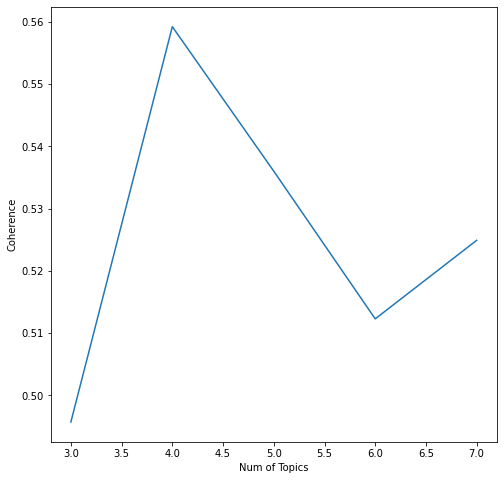

In [ ]:
x_axis = range(num_of_topics_start, num_of_topics_end, 1)
ax = plt.subplots(figsize=(8,8))
plt.plot(x_axis, coherence_values)
plt.xlabel('Num of Topics')
plt.ylabel('Coherence')
plt.show()

In [ ]:
# Final model with best # topics
lda = gensim.models.LdaMulticore(corpus=df1, id2word=dic, num_topics=4, chunksize=100, passes=500, per_word_topics=True, random_state=100)

In [ ]:
coherence_model1 = CoherenceModel(model=lda, texts=summaries, dictionary=dic, coherence='c_v')
score = coherence_model1.get_coherence()
print('Score', score)

Score 0.5762807462591446


In [ ]:
pprint(lda.print_topics(num_topics=6))
dic_lda = lda[df1]

[(0,
  '0.051*"cancelmortgage" + 0.031*"open" + 0.031*"cancelpropertytax" + '
  '0.030*"small" + 0.030*"court" + 0.028*"entire" + 0.028*"policy" + '
  '0.027*"consequence" + 0.027*"burden" + 0.026*"unconstitutional"'),
 (1,
  '0.028*"stopasianhatecrimes" + 0.020*"stopaapihate" + 0.018*"asian" + '
  '0.011*"hateisavirus" + 0.009*"today" + 0.009*"racist" + 0.009*"man" + '
  '0.008*"new" + 0.008*"teenvogue" + 0.008*"time"'),
 (2,
  '0.050*"asian" + 0.038*"hate" + 0.023*"community" + 0.021*"stop" + '
  '0.020*"american" + 0.017*"crime" + 0.014*"people" + 0.014*"racism" + '
  '0.014*"amp" + 0.014*"thank"'),
 (3,
  '0.042*"stopaapihate" + 0.026*"asianlivesmatter" + 0.025*"blacklivesmatter" '
  '+ 0.017*"stopthehate" + 0.016*"news" + 0.014*"nbcnews" + 0.013*"jlin" + '
  '0.012*"msnbc" + 0.011*"nowthisnews" + 0.010*"abcnews"')]


### Visualize topic modeling result

In [ ]:
#visualize topic modeling result
import pyLDAvis
import pyLDAvis.gensim_models
import pickle 

pyLDAvis.enable_notebook()
graph = pyLDAvis.gensim_models.prepare(lda, df1, dic)
graph
pyLDAvis.save_html(graph, 'lda.html')

/Users/zorak/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/Users/zorak/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/zorak/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/zorak/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/zorak/opt/anaconda3/lib/python3.9/s

### Topic modeling for After 316 (i.e. after event2)

In [ ]:
after_316 = pd.read_csv('after_316.csv')
norma = np.vectorize(norm)
norm_after_316 = norma(after_316['Text'])

In [ ]:
token_after_norm_df = [word_tokenize(i) for i in norm_after_316]
dic = corpora.Dictionary(token_after_norm_df)
dic.filter_extremes()

summaries = token_after_norm_df
df2 = [dic.doc2bow(i) for i in summaries]

In [ ]:
num_of_topics_start = 3
num_of_topics_end = 8
model_list2, coherence_values2 = coherence(df2, dic, summaries, num_of_topics_end, num_of_topics_start, 1)


### To find out the optimum number of topics

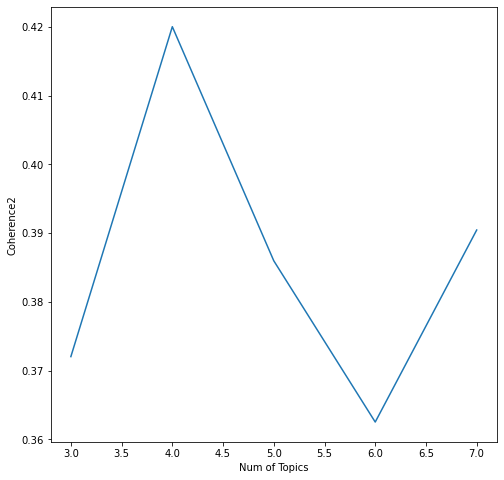

In [ ]:
x_axis = range(num_of_topics_start, num_of_topics_end, 1)
ax = plt.subplots(figsize=(8,8))
plt.plot(x_axis, coherence_values2)
plt.xlabel('Num of Topics')
plt.ylabel('Coherence2')
plt.show()

In [ ]:
# Final model with best # topics
lda = gensim.models.LdaMulticore(corpus=df2, id2word=dic, num_topics=4, chunksize=100, passes=500, per_word_topics=True, random_state=100)


In [ ]:
coherence_model2 = CoherenceModel(model=lda, texts=summaries, dictionary=dic, coherence='c_v')
score = coherence_model2.get_coherence()
print('Score', score)

Score 0.4338679915436449


In [ ]:
pprint(lda.print_topics(num_topics=6))
dic_lda = lda[df2]

[(0,
  '0.098*"stopaapihate" + 0.092*"stopasianhatecrimes" + 0.021*"please" + '
  '0.016*"asianstarsspeakupforasians" + 0.014*"thank" + 0.013*"rally" + '
  '0.010*"im" + 0.010*"nyc" + 0.008*"sorry" + 0.008*"park"'),
 (1,
  '0.033*"asian" + 0.025*"community" + 0.024*"racism" + 0.018*"u" + '
  '0.017*"stand" + 0.017*"aapi" + 0.017*"support" + 0.016*"amp" + '
  '0.016*"solidarity" + 0.016*"atlanta"'),
 (2,
  '0.041*"asian" + 0.019*"hate" + 0.018*"people" + 0.015*"stop" + 0.012*"u" + '
  '0.011*"dont" + 0.009*"one" + 0.009*"like" + 0.009*"white" + 0.009*"need"'),
 (3,
  '0.033*"e" + 0.032*"de" + 0.030*"stopasianhatecrimes" + 0.028*"matter" + '
  '0.026*"asianlivesmatter" + 0.024*"asiansarehuman" + 0.024*"que" + '
  '0.021*"life" + 0.016*"asian" + 0.016*"por"')]


### Visualize topic modeling result

In [ ]:
#visualize topic modeling result

pyLDAvis.enable_notebook()
graph = pyLDAvis.gensim_models.prepare(lda, df2, dic)
graph
pyLDAvis.save_html(graph, 'after_316.html')

/Users/zorak/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/zorak/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/zorak/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/zorak/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


We then selected the main 4 topics based on the most important words related to each topic category. For the posts before 316, the most-weighted words for the 4 topics are Asian, stopasiannhatecrimes, stopaapihate and cancelmortage. And for the posts after 316, the most-weighted words for the 4 topics are Asian, community, stopaapihate and stopasianhatecrimes. Furthermore, for the posts after 316, the top-weighted words in the fourth topic category become significantly more radical compared with that for the posts before 316, including some words such as “asian lives matter” and “asian are humans”. Therefore we can conclude that both the social engagement of this racial issue and topic relevance on social media have been dramatically improved after March 16th.

### World cloud

In [ ]:
def tokenizer(words) -> list:
    tokenizer = RegexpTokenizer(r'[\w-]+')
    tokens = tokenizer.tokenize(words.lower())

    stopwords_set = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    return [lemmatizer.lemmatize(token, pos='v') for token in tokens if token not in stopwords_set]

before_316 = pd.read_csv('before_316.csv')
after_316 = pd.read_csv('after_316.csv')
#apply tokenizer function to each post, using set to remove the repeat and store in processed text
post_before316 = before_316['Text'].astype(str).to_list()
post_after316 = after_316['Text'].astype(str).to_list()

processed_before316 = []
for comment in post_before316:
    processed_before316.append(list(set(tokenizer(comment))))
    
processed_after316 = []
for comment in post_after316:
    processed_after316.append(list(set(tokenizer(comment))))

In [ ]:
processed_before316_st = ''
for i in range(len(processed_before316)):
    for j in processed_before316[i]:
        processed_before316_st += j + ' '
            
processed_after316_st = ''
for i in range(len(processed_after316)):
    for j in processed_after316[i]:
        processed_after316_st += j + ' '


In [ ]:
icon = Image.open("123.png")
image_mask = Image.new(mode='RGB', size = icon.size, color = (255,255,255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) #converts the image object to an array

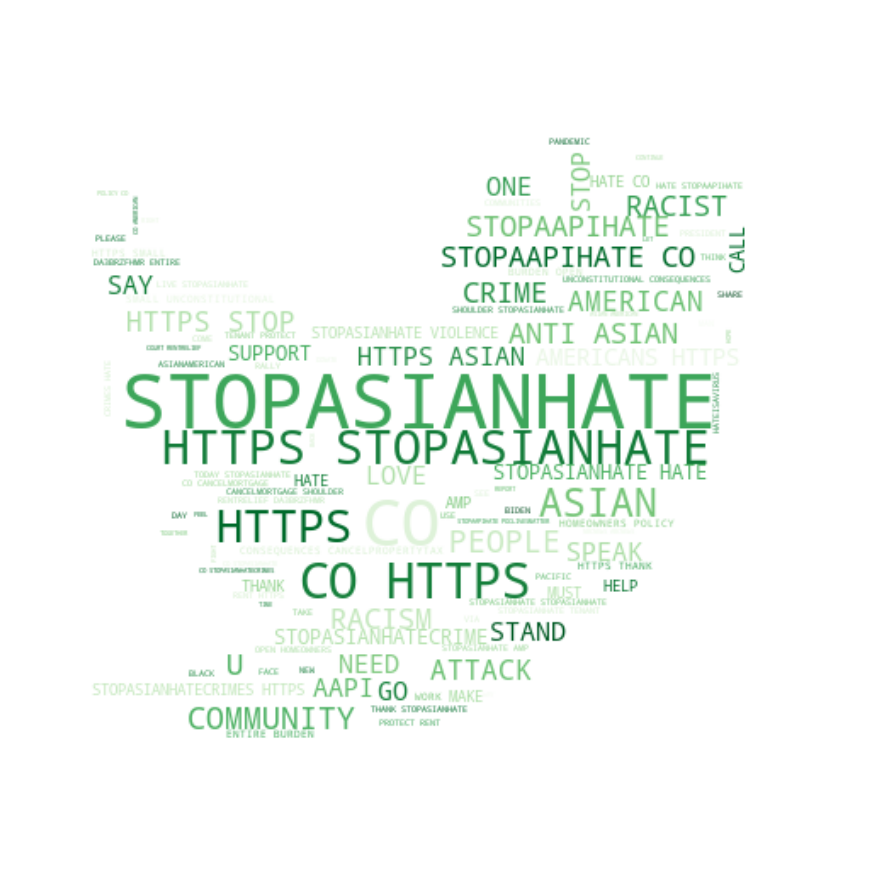

In [ ]:
word_cloud = WordCloud(mask=rgb_array, background_color = 'white', max_words = 500, colormap = 'Greens', max_font_size = 2000)
word_cloud.generate(processed_before316_st.upper())

plt.figure(figsize=[32,16])
plt.imshow(word_cloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

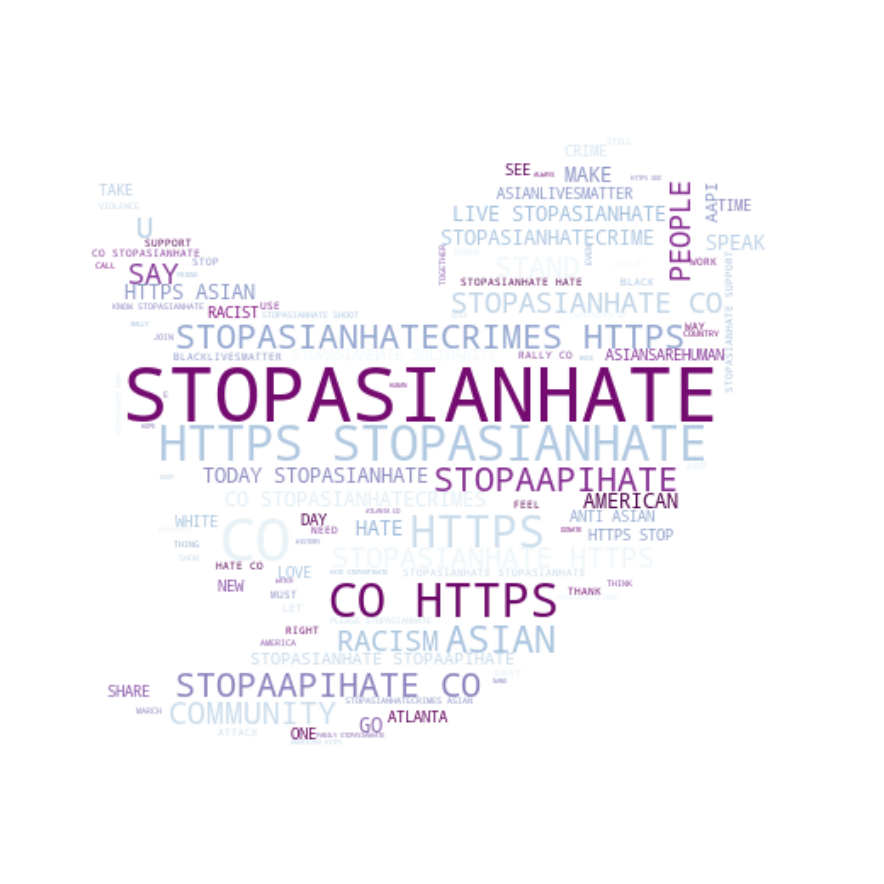

In [ ]:
word_cloud = WordCloud(mask=rgb_array, background_color = 'white', max_words = 500, colormap = 'BuPu', max_font_size = 2000)
word_cloud.generate(processed_after316_st.upper())

plt.figure(figsize=[32,16])
plt.imshow(word_cloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()


In accordance with the two WordClouds based on the Twitter posts one week
before and after the Atlantic Shooting, there is a significant convergent trend in the word selection in describing this serious social issue. In addition, some irrelevant topics such
as “cancelmortgage” disappeared after March 16th, indicating that society has gradually
realized the seriousness of this problem and reduced other irrelevant topics to chase
the clout.

## Task: Analyze Events 3
### New York Subway Shoving Attack in 2022

We scraped all the antiasianhate hashtag discussions on Twitter in the week
following the shoving attack. Because after one week, an entertainer posted a tweet
with the hashtag "stopasianhate" that caused his followers to brush up on the topic.
Considering that after one week, the impact on the topic was no longer caused
by the subway pushing incident but by the entertainer, we only scraped the data within
one week of the subway pushing incident.

In [ ]:
#import dataset
data = pd.read_csv('tweets_NYTS_asianwomandies.csv')
data_text = data['Text']
#data_text['index'] = data_text.index
documents = data_text


In [ ]:
#explore the data
print(len(documents))
print(documents[:5])

In [ ]:
punctuation_tokenizer = nltk.WordPunctTokenizer()
stop = nltk.corpus.stopwords.words('english')
stop_defined_by_me = ['de','u','yao','via','le','que'] #these are the unuseful words appeared in lda.html after we visulize the LDA model
lemmer = nltk.WordNetLemmatizer()

def norm(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    text = text.lower()
    text = text.strip()

    words = punctuation_tokenizer.tokenize(text)
    filtered_words1 = [word for word in words if word not in stop]
    filtered_words = [word for word in filtered_words1 if word not in stop_defined_by_me]
    lemmer_text = [lemmer.lemmatize(i) for i in filtered_words]
    lemmer_text = [word for word in lemmer_text if not word.isnumeric()]

    text = ' '.join(lemmer_text)

    return text

norma = np.vectorize(norm)
norm_documents = norma(documents)

### Topic Modeling
To better understand the concerns of netizens about this incident, we applied the
topic modeling technique to our data.

In [ ]:
token_norm_documents = [word_tokenize(i) for i in norm_documents]
dic = corpora.Dictionary(token_norm_documents)
print(dic)
print(dic.token2id)
dic.filter_extremes()

summaries = token_norm_documents
df = [dic.doc2bow(i) for i in summaries]

#use coherence map to find the optimal number of topics
def coherence(df, dic, summaries, finish, begin, step):
    values = []
    a_list = []

    for topics in tqdm(range(begin, finish, step)):
        lda = gensim.models.LdaMulticore(corpus=df, id2word=dic, num_topics=topics, chunksize=100, passes=500, per_word_topics=True, random_state=100)
        a_list.append(lda)

        coherence = CoherenceModel(model=lda, texts=summaries, dictionary=dic, coherence='c_v')
        values.append(coherence.get_coherence())

    return a_list, values

num_of_topics_start = 3
num_of_topics_end = 10
model_list, coherence_values = coherence(df, dic, summaries, num_of_topics_end, num_of_topics_start, 1)

x_axis = range(num_of_topics_start, num_of_topics_end, 1)
ax = plt.subplots(figsize=(8,8))
plt.plot(x_axis, coherence_values)
plt.xlabel('Num of Topics')
plt.ylabel('Coherence')
plt.show() # from the plot we can see that the optimal number of topics are 4

# Create Final model with best # topics
lda = gensim.models.LdaMulticore(corpus=df, id2word=dic, num_topics=4, chunksize=100, passes=500, per_word_topics=True, random_state=100)

coherence_model = CoherenceModel(model=lda, texts=summaries, dictionary=dic, coherence='c_v')
score = coherence_model.get_coherence()
print('Score', score)

pprint(lda.print_topics(num_topics=4))

dic_lda = lda[df]

#visualize topic modeling result

pyLDAvis.enable_notebook()
graph = pyLDAvis.gensim_models.prepare(lda, df, dic)
graph
pyLDAvis.save_html(graph, 'lda_cleaned.html')

#top 3 topics for each tweet
lda_dict = {
    0:'asian hate crime & dont need violence',
    1:'racist & racism, blacklivesmatter',
    2:'nyc subway asian woman michelle pushed death',
    3:'stopasianhatecrime & stopaapihate',
    '#':'#'
    }

topics_df1 = pd.DataFrame()
topics_df2 = pd.DataFrame()
topics_df3 = pd.DataFrame()

for i, row in enumerate(lda[df]):
    row = row[0] if lda.per_word_topics else row
    row = sorted(row, key=lambda x: (x[1]), reverse=True)

    for j, (topic_num, prop) in enumerate(row):
        if len(row) >= 3:
            if j == 0:
                topics_df1 = topics_df1.append(pd.Series([int(topic_num), prop]), ignore_index=True)
            elif j == 1:
                topics_df2 = topics_df2.append(pd.Series([int(topic_num), prop]), ignore_index=True)
            elif j == 2:
                topics_df3 = topics_df3.append(pd.Series([int(topic_num), prop]), ignore_index=True)
            else:
                break
        elif len(row) == 2:
            if j == 0:
                topics_df1 = topics_df1.append(pd.Series([int(topic_num), prop]), ignore_index=True)
            elif j == 1:
                topics_df2 = topics_df2.append(pd.Series([int(topic_num), prop]), ignore_index=True)
                topics_df3 = topics_df3.append(pd.Series(['#', '#']), ignore_index=True)
        elif len(row) == 1:
            topics_df1 = topics_df1.append(pd.Series([int(topic_num), prop]), ignore_index=True)
            topics_df2 = topics_df2.append(pd.Series(['#', '#']), ignore_index=True)
            topics_df3 = topics_df3.append(pd.Series(['#', '#']), ignore_index=True)

topics_df1.rename(columns={0: '1st Topic', 1:'1st Topic Contribution'}, inplace=True)
topics_df2.rename(columns={0: '2nd Topic', 1:'2nd Topic Contribution'}, inplace=True)
topics_df3.rename(columns={0: '3rd Topic', 1:'3rd Topic Contribution'}, inplace=True)
combo = pd.concat([topics_df1, topics_df2, topics_df3],  axis=1, sort=False)
data = pd.concat([data, combo], axis=1, sort=False)

#Combine the top 3 into one column so it's easier to analyse
data['Top 3 Topics'] = data['1st Topic'].apply(lambda x: lda_dict[x].join(" ,") + " ").astype(str) + data['2nd Topic'].apply(lambda x: lda_dict[x].join(" ,") + " ").astype(str) + data['3rd Topic'].apply(lambda x: lda_dict[x]).astype(str)

#output the result csv 
data.to_csv('20220115_NYSubway_TopicModeling.csv')

From the topic modeling analysis, we can see that people have richer emotions
about the phenomenon of racial hatred, from angry hatred to rational control, which also
represents the netizens' greater attention to the topic of ‘stopasianhate’.

## Task: Network Visualization Analysis
### Relevant output can be found in data file

The data we are using for network visualization are tweets data before the
Atlantic shooting and after the New York subway shoving attack. We converted the tweets data we got from the scraper to a format of three columns,  where the first two columns
represent the two users, and column three represents whether the second person is
retweeting/replying/referencing the first person, or this is an original post.

Using the data we got from the previous step, we then create the two network
visualizations of the two datasets. We also simplify the network using
the dynamic filters function of NodeXL, for example, we increase their minimum
degrees to the same level so as to decrease the number of meaningless edges from the two
graphs. Note that different colors of data points represent they belong to different
clusters.

By comparing the two network visualizations, it can be found that before the
Atlantic shooting, people discussing these were mostly individuals and more
disorganized and aggressive. However, after the New York subway shoving attack,
many mainstream media outlets joined the discussion and the discussion is more
moderate and regulated. For example, nypmetro(New York Post Metro) is the node with
a relatively high degree of 27 within the graph, which shows that the mainstream media
has played an active role in guiding public opinion. This is uplifting since the
mainstream media is gradually leading the masses toward a more positive and
peace-oriented attitude.

## Insights of the Project
###  Influence of Public Figure
Although hate crimes targeting Asian and other minorities have existed for
decades, based on the research conducted by professionals and our analysis, we
cannot deny the fact that a huge negative impact was brought by Donald Trump's post.
From social media analysis, we can easily understand how quickly these words spread.
Therefore, public figures should be more cautious when posting sensitive content on
social media and should always consider the possible negative result it can bring to society.

### Power of Consist Hashtag
When scrapping the data for our project, we found some time we cannot scrap
any data with the keyword #StopAsianHate even though there were hate crimes
targeting Asians happening at the same time, and there were people who continuously
speak up for this issue. Until March 2021 when #StopAsianHate became a
well-known slogan for this Anti-hate crime targeting Asian, public voices started to
aggregate and bring this movement more attention. Therefore, whether a social
movement or a marketing campaign is trying to gain more attention and influence, it is
important to make sure people who participate in the discussions are contributing to the
same topic so the heat won’t be diluted.